In [ ]:
# https://pub.towardsai.net/recommendation-system-in-depth-tutorial-with-python-for-netflix-using-collaborative-filtering-533ff8a0e444

# Recommendation System Tutorial with Python using Collaborative Filtering

In [34]:
# Download datasets
!wget https://zenodo.org/record/4556134/files/combined_data_4.txt?download=1

import wget

url1 = 'https://raw.githubusercontent.com/towardsai/tutorials/master/recommendation_system_tutorial/movie_titles.csv'
url2 = 'https://raw.githubusercontent.com/towardsai/tutorials/master/recommendation_system_tutorial/new_features.csv'
wget.download(url1)
wget.download(url2)

100% [............................................................] 6328 / 6328

'new_features.csv'

In [ ]:
# !pip install scikit-surprise

In [35]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

import xgboost as xgb
from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV

In [36]:
def load_data():
    netflix_csv_file = open("netflix_rating.csv", mode = "w")
    rating_files = ['combined_data_4.txt'] 
    for file in rating_files:
        with open(file) as f:
            for line in f:
                line = line.strip()
                if line.endswith(":"):
                    movie_id = line.replace(":", "")
                else:
                    row_data = []
                    row_data = [item for item in line.split(",")]
                    row_data.insert(0, movie_id)
                    netflix_csv_file.write(",".join(row_data))  
                    netflix_csv_file.write('\n')
                    
    netflix_csv_file.close()
    df = pd.read_csv('netflix_rating.csv', sep=",", names = ["movie_id","customer_id", "rating", "date"])
    return df

In [37]:
netflix_rating_df = load_data()
netflix_rating_df
netflix_rating_df.head()

,movie_id,customer_id,rating,date
0,13368,2385003,4,2004-07-08
1,13368,659432,3,2005-03-16
2,13368,751812,2,2002-12-16
3,13368,2625420,2,2004-05-25
4,13368,1650301,1,2005-08-30


In [6]:
netflix_rating_df.duplicated(["movie_id","customer_id", "rating", "date"]).sum()

0

In [38]:
split_value = int(len(netflix_rating_df) * 0.80)
train_data = netflix_rating_df[:split_value]
test_data = netflix_rating_df[split_value:]

/var/folders/sk/vjx0mjtn47n5sg33shl7ll400000gn/T/ipykernel_16713/1023361842.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([num for num in ax.get_yticks()])


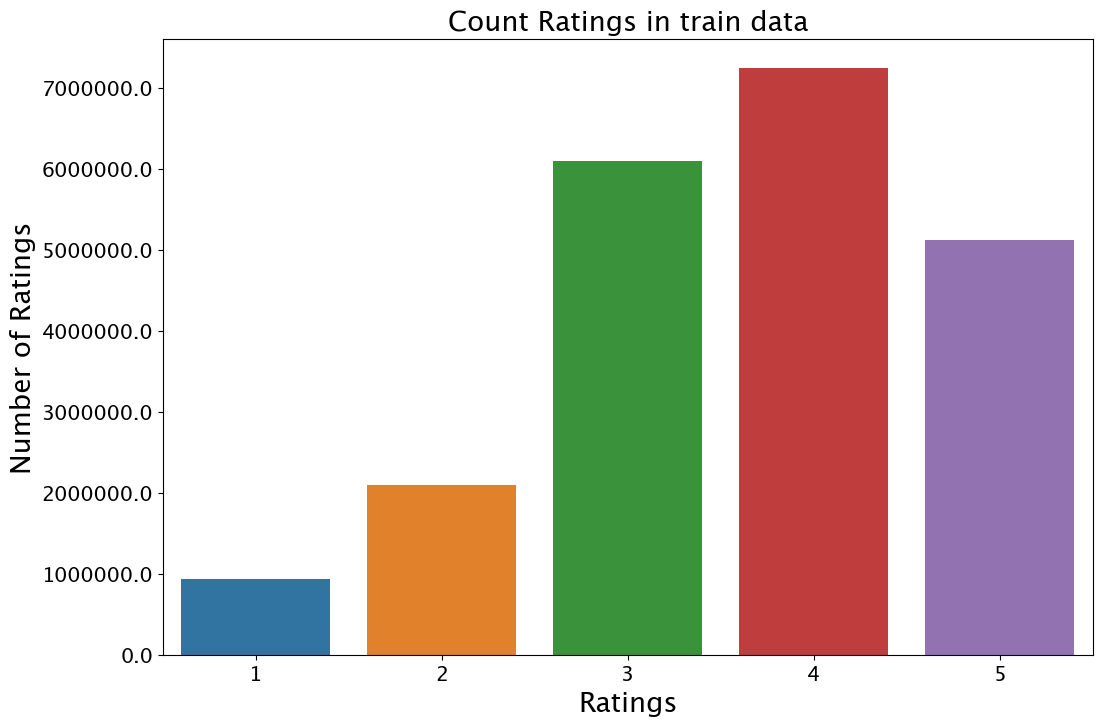

In [39]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="rating", data=train_data)

ax.set_yticklabels([num for num in ax.get_yticks()])

plt.tick_params(labelsize = 15)
plt.title("Count Ratings in train data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()

In [ ]:
# Create User-Item Sparse Matrix

In [40]:
def get_user_item_sparse_matrix(df):
    sparse_data = sparse.csr_matrix((df.rating, (df.customer_id, df.movie_id)))
    return sparse_data

In [41]:
# User-item Train Sparse matrix
train_sparse_data = get_user_item_sparse_matrix(train_data)

In [42]:
# User-item test sparse matrix
test_sparse_data = get_user_item_sparse_matrix(test_data)

In [43]:
# Global Average Rating
global_average_rating = train_sparse_data.sum()/train_sparse_data.count_nonzero()
print("Global Average Rating: {}".format(global_average_rating))

Global Average Rating: 3.6291294662291467


In [44]:
# Calculate the average rating
def get_average_rating(sparse_matrix, is_user):
    ax = 1 if is_user else 0
    sum_of_ratings = sparse_matrix.sum(axis = ax).A1  
    no_of_ratings = (sparse_matrix != 0).sum(axis = ax).A1 
    rows, cols = sparse_matrix.shape
    average_ratings = {i: sum_of_ratings[i]/no_of_ratings[i] for i in range(rows if is_user else cols) if no_of_ratings[i] != 0}
    return average_ratings

In [45]:
# Average Rating User
average_rating_user = get_average_rating(train_sparse_data, True)

In [46]:
# Average Rating Movie
avg_rating_movie = get_average_rating(train_sparse_data, False)

In [47]:
# Check Cold Start Problem: User
total_users = len(np.unique(netflix_rating_df["customer_id"]))
train_users = len(average_rating_user)
uncommonUsers = total_users - train_users
                  
print("Total no. of Users = {}".format(total_users))
print("No. of Users in train data= {}".format(train_users))
print("No. of Users not present in train data = {}({}%)".format(uncommonUsers, np.round((uncommonUsers/total_users)*100), 2))

Total no. of Users = 475601
No. of Users in train data= 473014
No. of Users not present in train data = 2587(1.0%)


In [ ]:
# Here, 1% of total users are new, and they will have no proper rating available. 
# Therefore, this can bring the issue of the cold start problem.

In [48]:
# Check Cold Start Problem: Movie
total_movies = len(np.unique(netflix_rating_df["movie_id"]))
train_movies = len(avg_rating_movie)
uncommonMovies = total_movies - train_movies
                  
print("Total no. of Movies = {}".format(total_movies))
print("No. of Movies in train data= {}".format(train_movies))
print("No. of Movies not present in train data = {}({}%)".format(uncommonMovies, np.round((uncommonMovies/total_movies)*100), 2))

Total no. of Movies = 4403
No. of Movies in train data= 3515
No. of Movies not present in train data = 888(20.0%)


In [ ]:
# Here, 20% of total movies are new, and their rating might not be available in the dataset. 
# Consequently, this can bring the issue of the cold start problem.

In [49]:
# Computation of user similarity to find similarities of the top 100 users:
def compute_user_similarity(sparse_matrix, limit=100):
    row_index, col_index = sparse_matrix.nonzero()
    rows = np.unique(row_index)
    similar_arr = np.zeros(61700).reshape(617,100)
    
    for row in rows[:limit]:
        sim = cosine_similarity(sparse_matrix.getrow(row), train_sparse_data).ravel()
        similar_indices = sim.argsort()[-limit:]
        similar = sim[similar_indices]
        similar_arr[row] = similar
    
    return similar_arr

In [50]:
similar_user_matrix = compute_user_similarity(train_sparse_data, 100)

In [51]:
similar_user_matrix[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [57]:
# Compute Movie Similarity Matrix
# Load movies title data set

movie_titles_df = pd.read_csv("movie_titles.csv", sep = ",", header = None, on_bad_lines='skip', 
                              names=['movie_id', 'year_of_release', 'movie_title'],
                              index_col = "movie_id", encoding = "iso8859_2")
movie_titles_df.head()

,year_of_release,movie_title
movie_id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


In [60]:
# Compute similar movies:
def compute_movie_similarity_count(sparse_matrix, movie_titles_df, movie_id):
    similarity = cosine_similarity(sparse_matrix.T, dense_output = False)
    no_of_similar_movies = movie_titles_df.loc[movie_id][1], similarity[movie_id].count_nonzero()
    return no_of_similar_movies

In [61]:
# Get a similar movies list:
similar_movies = compute_movie_similarity_count(train_sparse_data, movie_titles_df, 1775)
print("Similar Movies = {}".format(similar_movies))

Similar Movies = ('Dario Argento Collection: Vol. 1: Phenomena', 0)


In [62]:
# Building the Machine Learning Model
# Create a Sample Sparse Matrix

def get_sample_sparse_matrix(sparse_matrix, no_of_users, no_of_movies):
    users, movies, ratings = sparse.find(sparse_matrix)
    uniq_users = np.unique(users)
    uniq_movies = np.unique(movies)
    np.random.seed(15) 
    user = np.random.choice(uniq_users, no_of_users, replace = False)
    movie = np.random.choice(uniq_movies, no_of_movies, replace = True)
    mask = np.logical_and(np.isin(users, user), np.isin(movies, movie))
    sparse_matrix = sparse.csr_matrix((ratings[mask], (users[mask], movies[mask])), 
                                                     shape = (max(user)+1, max(movie)+1))
    return sparse_matrix

In [63]:
# Sample Sparse Matrix for the training data:
train_sample_sparse_matrix = get_sample_sparse_matrix(train_sparse_data, 400, 40)

In [64]:
# Sample Sparse Matrix for the test data:
test_sparse_matrix_matrix = get_sample_sparse_matrix(test_sparse_data, 200, 20)

In [65]:
# Featuring the Data
# Featuring is a process to create new features by adding different aspects of variables.
def create_new_similar_features(sample_sparse_matrix):
    global_avg_rating = get_average_rating(sample_sparse_matrix, False)
    global_avg_users = get_average_rating(sample_sparse_matrix, True)
    global_avg_movies = get_average_rating(sample_sparse_matrix, False)
    sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_sparse_matrix)
    new_features_csv_file = open("new_features.csv", mode = "w")
    
    for user, movie, rating in zip(sample_train_users, sample_train_movies, sample_train_ratings):
        similar_arr = list()
        similar_arr.append(user)
        similar_arr.append(movie)
        similar_arr.append(sample_sparse_matrix.sum()/sample_sparse_matrix.count_nonzero())
        
        similar_users = cosine_similarity(sample_sparse_matrix[user], sample_sparse_matrix).ravel()
        indices = np.argsort(-similar_users)[1:]
        ratings = sample_sparse_matrix[indices, movie].toarray().ravel()
        top_similar_user_ratings = list(ratings[ratings != 0][:5])
        top_similar_user_ratings.extend([global_avg_rating[movie]] * (5 - len(ratings)))
        similar_arr.extend(top_similar_user_ratings)
        
        similar_movies = cosine_similarity(sample_sparse_matrix[:,movie].T, sample_sparse_matrix.T).ravel()
        similar_movies_indices = np.argsort(-similar_movies)[1:]
        similar_movies_ratings = sample_sparse_matrix[user, similar_movies_indices].toarray().ravel()
        top_similar_movie_ratings = list(similar_movies_ratings[similar_movies_ratings != 0][:5])
        top_similar_movie_ratings.extend([global_avg_users[user]] * (5-len(top_similar_movie_ratings)))
        similar_arr.extend(top_similar_movie_ratings)
        
        similar_arr.append(global_avg_users[user])
        similar_arr.append(global_avg_movies[movie])
        similar_arr.append(rating)
        
        new_features_csv_file.write(",".join(map(str, similar_arr)))
        new_features_csv_file.write("\n")
        
    new_features_csv_file.close()
    new_features_df = pd.read_csv('new_features.csv', names = ["user_id", "movie_id", "gloabl_average", "similar_user_rating1", 
                                                               "similar_user_rating2", "similar_user_rating3", 
                                                               "similar_user_rating4", "similar_user_rating5", 
                                                               "similar_movie_rating1", "similar_movie_rating2", 
                                                               "similar_movie_rating3", "similar_movie_rating4", 
                                                               "similar_movie_rating5", "user_average", 
                                                               "movie_average", "rating"])
    return new_features_df

In [66]:
# Featuring (adding new similar features) for the training data:
train_new_similar_features = create_new_similar_features(train_sample_sparse_matrix)

In [67]:
train_new_similar_features = train_new_similar_features.fillna(0)
train_new_similar_features.head()

,user_id,movie_id,gloabl_average,similar_user_rating1,similar_user_rating2,similar_user_rating3,similar_user_rating4,similar_user_rating5,similar_movie_rating1,similar_movie_rating2,similar_movie_rating3,similar_movie_rating4,similar_movie_rating5,user_average,movie_average,rating
0,368756,13393,3.392157,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0
1,2593137,13495,3.392157,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0
2,96842,13602,3.392157,3.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.5,5.0,0.0,0.0
3,486048,13602,3.392157,3.0,5.0,5.0,3.0,3.0,3.0,3.0,3.0,3.0,4.5,3.0,0.0,0.0
4,940434,13602,3.392157,3.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.5,5.0,0.0,0.0


In [68]:
# Featuring (adding new similar features) for the test data:
test_new_similar_features = create_new_similar_features(test_sparse_matrix_matrix)

In [69]:
test_new_similar_features = test_new_similar_features.fillna(0)
test_new_similar_features.head()

,user_id,movie_id,gloabl_average,similar_user_rating1,similar_user_rating2,similar_user_rating3,similar_user_rating4,similar_user_rating5,similar_movie_rating1,similar_movie_rating2,similar_movie_rating3,similar_movie_rating4,similar_movie_rating5,user_average,movie_average,rating
0,218348,16977,3.393939,4,1.0,5.0,4.0,3.0,5.0,5.0,5.000000,5.000000,5.000000,5.000000,3.583333,5.0
1,482111,16977,3.393939,4,1.0,5.0,4.0,3.0,3.0,3.0,3.000000,3.000000,3.000000,3.000000,3.583333,3.0
2,770495,16977,3.393939,4,1.0,5.0,4.0,3.0,4.0,4.0,4.000000,4.000000,4.000000,4.000000,3.583333,4.0
3,1033930,16977,3.393939,2,1.0,3.0,4.0,4.0,3.0,2.0,2.666667,2.666667,2.666667,2.666667,3.583333,3.0
4,1301848,16977,3.393939,4,1.0,5.0,4.0,3.0,4.0,4.0,4.000000,4.000000,4.000000,4.000000,3.583333,4.0


In [70]:
# Training and Prediction of the Model
# Divide the train and test data from the similar_features dataset:

x_train = train_new_similar_features.drop(["user_id", "movie_id", "rating"], axis = 1)

x_test = test_new_similar_features.drop(["user_id", "movie_id", "rating"], axis = 1)

y_train = train_new_similar_features["rating"]

y_test = test_new_similar_features["rating"]

In [71]:
# Utility method to check accuracy:
def error_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

In [72]:
# Fit to XGBRegressor algorithm with 100 estimators:
clf = xgb.XGBRegressor(n_estimators = 100, silent = False, n_jobs  = 10)
clf.fit(x_train, y_train)

[15:30:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=10, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [73]:
# Predict the result of the test data set:
y_pred_test = clf.predict(x_test)

In [74]:
# Check accuracy of predicted data:
rmse_test = error_metrics(y_test, y_pred_test)
print("RMSE = {}".format(rmse_test))

RMSE = 0.4554496392686637


In [75]:
# Plot Feature Importance - Feature importance is an important technique that selects a score to input features 
# based on how valuable they are at predicting a target variable.
def plot_importance(model, clf):
    fig = plt.figure(figsize = (8, 6))
    ax = fig.add_axes([0,0,1,1])
    model.plot_importance(clf, ax = ax, height = 0.3)
    plt.xlabel("F Score", fontsize = 20)
    plt.ylabel("Features", fontsize = 20)
    plt.title("Feature Importance", fontsize = 20)
    plt.tick_params(labelsize = 15)
    
    plt.show()

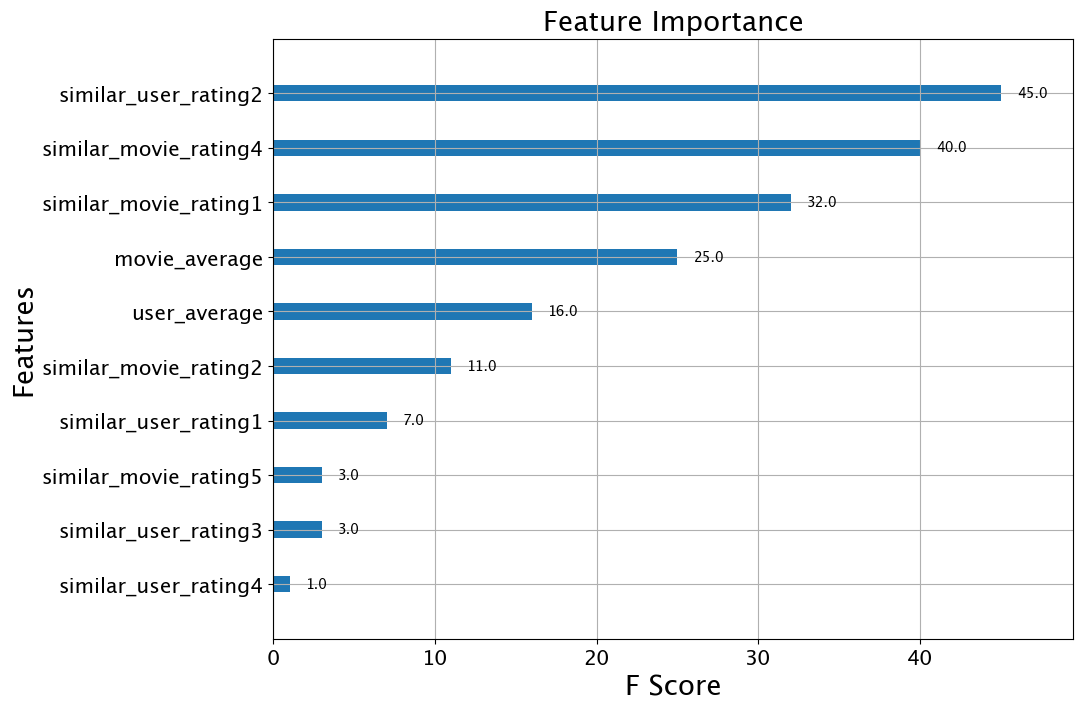

In [76]:
 # The plot shown in figure 25 displays the feature importance of each feature.
plot_importance(xgb, clf)